### Data Processing

In [20]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive',force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
import numpy as np
import torch
from torch.utils.data import DataLoader

# Make /src importable
PROJECT_ROOT = '/content/drive/MyDrive/3.Job Workspaces/RAShip/LWM/'
# PROJECT_ROOT = os.path.abspath(".")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)
print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Project root: g:\My Drive\3.Job Workspaces\RAShip\LWM
Torch: 2.10.0+cpu


device(type='cpu')

In [2]:
from src.data.wisdm import prepare_wisdm_windows, load_cached_wisdm
from src.data.windowing import WindowingConfig
from src.data.dataset_base import subject_wise_split, mask_from_subjects, subset_arrays, WindowDataset, save_splits_npz

WINDOW_SIZE = 50
STRIDE = 12
DATA_SECTION = '2_32' # What segmenmnt of dataset do we want. 'all' for all, or A_B for pairs


raw_path = os.path.join(PROJECT_ROOT, "raw", "WISDM_ar_v1.1_raw.txt")
cache_path = os.path.join(PROJECT_ROOT, "data", "processed", f"wisdm_w{WINDOW_SIZE}_s{STRIDE}.npz")

win_cfg = WindowingConfig(window_size=WINDOW_SIZE, stride=STRIDE, min_segment_len=WINDOW_SIZE)

if os.path.exists(cache_path):
    prepared = load_cached_wisdm(cache_path)
    print("Loaded cache:", cache_path)
else:
    prepared = prepare_wisdm_windows(
        raw_path=raw_path,
        window_cfg=win_cfg,
        cache_path=cache_path,
        verbose=True,
    )

X, y, subjects = prepared.X, prepared.y, prepared.subjects
X.shape, y.shape, subjects.shape, np.unique(y, return_counts=True)
np.unique(subjects, return_counts=True)


Loaded cache: g:\My Drive\3.Job Workspaces\RAShip\LWM\data\processed\wisdm_w50_s12.npz


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36]),
 array([2446, 1946, 2868,  918, 2331, 1472, 2452, 3275, 1070, 2860, 2594,
        2559, 2129, 3140, 1110, 1684, 1612, 1803, 3714, 3313, 1881, 1822,
        2107, 2094, 1095, 2672, 1573, 1750, 1924, 2079, 3634, 1748, 2171,
        2946, 1844, 2387]))

In [23]:
# Prepare explicit train->test subject pairs and extract X/y for each
pairs = [
    (4, 15),
    (2, 25),
    (25, 29),
    (7, 30),
    (21, 31),
    (2, 32),
    (1, 7),
]

# Dictionaries to hold results per pair key 'sx_sy'
pair_data = {}

for sx, sy in pairs:
    key = f"{sx}_{sy}"
    # masks: train uses only subject sx, test uses only subject sy
    m_train = mask_from_subjects(subjects, [sx])
    m_val = mask_from_subjects(subjects, [3]) # subject 3 is always val
    m_test  = mask_from_subjects(subjects, [sy])

    X_tr, y_tr, s_tr = subset_arrays(X, y, subjects, m_train)
    X_va, y_va, s_va = subset_arrays(X, y, subjects, m_val)
    X_te, y_te, s_te = subset_arrays(X, y, subjects, m_test)

    pair_data[key] = {
        'X_tr': X_tr, 'y_tr': y_tr, 's_tr': s_tr,
        'X_va': X_va, 'y_va': y_va, 's_va': s_va,
        'X_te': X_te, 'y_te': y_te, 's_te': s_te,
    }

    print(f"Pair {sx} → {sy}: train={X_tr.shape} val={X_va.shape} test={X_te.shape}")

# Example access: pair_data['4_15']['X_tr'], pair_data['4_15']['y_te']



Pair 4 → 15: train=(918, 50, 3) val=(2868, 50, 3) test=(1110, 50, 3)
Pair 2 → 25: train=(1946, 50, 3) val=(2868, 50, 3) test=(1095, 50, 3)
Pair 25 → 29: train=(1095, 50, 3) val=(2868, 50, 3) test=(1924, 50, 3)
Pair 7 → 30: train=(2452, 50, 3) val=(2868, 50, 3) test=(2079, 50, 3)
Pair 21 → 31: train=(1881, 50, 3) val=(2868, 50, 3) test=(3634, 50, 3)
Pair 2 → 32: train=(1946, 50, 3) val=(2868, 50, 3) test=(1748, 50, 3)
Pair 1 → 7: train=(2446, 50, 3) val=(2868, 50, 3) test=(2452, 50, 3)


In [24]:
# Tring for only one pair first

if DATA_SECTION == "all":
    rng = np.random.default_rng(seed=42)

    unique_subjects = np.unique(subjects)
    rng.shuffle(unique_subjects)

    train_subjects = unique_subjects[:14]
    val_subjects   = unique_subjects[14:16]
    test_subjects  = unique_subjects[16:]


    m_train = mask_from_subjects(subjects, train_subjects)
    m_val = mask_from_subjects(subjects, val_subjects)
    m_test  = mask_from_subjects(subjects, test_subjects)

    X_tr, y_tr, s_tr = subset_arrays(X, y, subjects, m_train)
    X_va, y_va, s_va = subset_arrays(X, y, subjects, m_val)
    X_te, y_te, s_te = subset_arrays(X, y, subjects, m_test)

else:

    X_tr = pair_data[DATA_SECTION]['X_tr']
    y_tr = pair_data[DATA_SECTION]['y_tr']
    s_tr = pair_data[DATA_SECTION]['s_tr']

    X_va = pair_data[DATA_SECTION]['X_va']
    y_va = pair_data[DATA_SECTION]['y_va']
    s_va = pair_data[DATA_SECTION]['s_va']

    X_te = pair_data[DATA_SECTION]['X_te']
    y_te = pair_data[DATA_SECTION]['y_te']
    s_te = pair_data[DATA_SECTION]['s_te']

# We dont need the subject id as our model is only supposed to pick between source subject and target subject
# After you have X_tr, y_tr, s_tr, X_va, y_va, s_va, X_te, y_te, s_te
s_tr = np.zeros_like(s_tr)          # train domain = 0
s_va = np.ones_like(s_va)           # val domain   = 1
s_te = np.ones_like(s_te)           # test domain  = 1

X_tr.shape, y_tr.shape, s_tr.shape, np.unique(y_tr, return_counts=True)

((1946, 50, 3), (1946,), (1946,), (array([0, 1]), array([971, 975])))

In [25]:
# Fit normalization on train set
train_tmp = WindowDataset(np.concatenate([X_tr, X_te]), np.concatenate([y_tr, y_te]), np.concatenate([s_tr, s_te]), standardize=True)
mean, std = train_tmp.mean, train_tmp.std
print("mean:", mean, "std:", std)
batch_size = 256

ds_train = WindowDataset(X_tr, y_tr, s_tr, standardize=True, mean=mean, std=std)
ds_val   = WindowDataset(X_va, y_va, s_va, standardize=True, mean=mean, std=std)
ds_test  = WindowDataset(X_te, y_te, s_te, standardize=True, mean=mean, std=std)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


mean: [-0.7334972   6.5236773  -0.16084972] std: [6.9078565 5.9444866 4.535898 ]


In [26]:
splits_path = os.path.join(PROJECT_ROOT, "data", "processed",f"wisdm_splits_{DATA_SECTION}_w{WINDOW_SIZE}_st{STRIDE}.npz")
meta = {
    "DATA_SECTION": DATA_SECTION,
    "WINDOW_SIZE": WINDOW_SIZE,
    "STRIDE": STRIDE,
    "batch_size": batch_size,
    }

save_splits_npz(
    splits_path,
    X_tr=X_tr, y_tr=y_tr, s_tr=s_tr,
    X_va=X_va, y_va=y_va, s_va=s_va,
    X_te=X_te, y_te=y_te, s_te=s_te,
    mean=mean, std=std,
    meta=meta
)

Saved splits to: /content/drive/MyDrive/3.Job Workspaces/RAShip/LWM/data/processed/wisdm_splits_2_32_w50_st12.npz


### Model Config and Training

In [27]:
from src.backbones.lstm import LSTMEncoder, LSTMDecoder, LSTMEncoderConfig, LSTMDecoderConfig
from src.models.dts_vae import DTSVAE, DTSVAEConfig

history = {
    "epoch": [],
    "train": [],
    "val": [],
}

T, C = X.shape[1], X.shape[2]

latent_dim = 8
enc_cfg = LSTMEncoderConfig(input_size=C, hidden_size=32, num_layers=1, dropout=0.02, bidirectional=False)
dec_cfg = LSTMDecoderConfig(output_size=C, latent_dim=latent_dim, hidden_size=32, num_layers=1, dropout=0.02)

encoder = LSTMEncoder(enc_cfg)
decoder = LSTMDecoder(dec_cfg)

num_subjects = 2#int(np.max(subjects)) + 1  # subjects are 1..36; this makes room for index == 36
# Better: remap subjects to 0..K-1, but this works if IDs are dense-ish.

model_cfg = DTSVAEConfig(
    latent_dim=latent_dim,
    act_dim=6,
    loss_type="group",

    # STABILIZATION FIX:
    # 1. Reduce alpha to prevent negative loss explosion.
    #    Start with alpha=0.0 (Standard VAE) to verify baseline works.
    #    Then try alpha=1.0 (if beta=1.0) to neutralize the marginal KL penalty (InfoVAE-style).
    alpha=0.0,
    beta=0.0,

    recon_loss="mse",
    num_classes=6,
    cls_weight=1.0,  # Keep this strong so activity classification is learned

    use_grl=True,
    num_subjects=num_subjects,
    grl_lambda=1.0,

    head_hidden_dim = 64,
    head_dropout = 0.0,

    # DISENTANGLEMENT FIX:
    # 2. Increase Adversarial weights relative to Reconstruction (usually ~1.0)
    #    If mu_act still contains subject info, boost this to 2.0 or 5.0.
    subj_weight=1.0,      # Force mu_subj to learn subject info
    subj_adv_weight=2.5,  # Penalize mu_act strongly if it leaks subject info
    act_adv_weight=2.5,
)


model = DTSVAE(model_cfg, encoder=encoder, decoder=decoder).to(device)
model


DTSVAE(
  (encoder): LSTMEncoder(
    (lstm): LSTM(3, 32, batch_first=True)
  )
  (decoder): LSTMDecoder(
    (lstm): LSTM(8, 32, batch_first=True)
    (proj): Linear(in_features=32, out_features=3, bias=True)
  )
  (to_mu): Linear(in_features=32, out_features=8, bias=True)
  (to_logvar): Linear(in_features=32, out_features=8, bias=True)
  (activity_head): MLPHead(
    (net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=6, bias=True)
    )
  )
  (subject_head): MLPHead(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (grl): GradientReversal()
  (subject_head_adv): MLPHead(
    (net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (activity_head_adv): MLPH

In [28]:
import math

def linear_ramp(epoch, start, end, final_value):
    """
    0 before start, linearly ramps to final_value between [start, end],
    stays at final_value after end.
    """
    if epoch < start:
        return 0.0
    if epoch >= end:
        return float(final_value)
    p = (epoch - start) / max(1, (end - start))
    return float(final_value) * float(p)

def grl_schedule(epoch, warmup_start=10, warmup_end=40):
    """
    Returns (grl_lambda, subj_adv_weight, act_adv_weight).
    """
    grl_l = linear_ramp(epoch, warmup_start, warmup_end, final_value=1.0)
    subj_adv_w = linear_ramp(epoch, warmup_start, warmup_end, final_value=model.cfg.subj_adv_weight)
    act_adv_w  = linear_ramp(epoch, warmup_start, warmup_end, final_value=model.cfg.act_adv_weight)
    return grl_l, subj_adv_w, act_adv_w


In [29]:
import time
import torch
import torch.nn as nn

# --- 1. Define Helper for Scheduling ---
def linear_schedule(epoch: int, start_epoch: int, end_epoch: int, start_val: float, end_val: float) -> float:
    """Linearly ramps a value from start_val to end_val between start_epoch and end_epoch."""
    if epoch < start_epoch:
        return start_val
    if epoch >= end_epoch:
        return end_val
    # Linear interpolation
    alpha_val = (epoch - start_epoch) / (end_epoch - start_epoch)
    return start_val + alpha_val * (end_val - start_val)

# --- 2. Setup Training State ---
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epochs = 2500
start_epoch = max_epochs #

In [30]:
import os

CKPT_DIR = os.path.join(PROJECT_ROOT, "checkpoints", "DTSVAE")  # change name if you want
os.makedirs(CKPT_DIR, exist_ok=True)

def save_checkpoint(epoch: int, *, tag: str = None):
    tag = tag or f"{DATA_SECTION}_epoch_{model_cfg.latent_dim}L_H{model_cfg.head_hidden_dim}_D{dec_cfg.hidden_dim}_{epoch:04d}"
    ckpt_path = os.path.join(CKPT_DIR, f"ckpt_{tag}.pt")

    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "opt_state": opt.state_dict(),
        "history": history,
        "cfg": getattr(model, "cfg", None),  # handy if cfg is a dataclass / simple obj
    }
    torch.save(ckpt, ckpt_path)
    # also keep an easy "latest" pointer
    torch.save(ckpt, os.path.join(CKPT_DIR, "ckpt_latest.pt"))
    print(f"[ckpt] saved: {ckpt_path}")

In [31]:
RESUME_PATH = None#os.path.join(CKPT_DIR, f"ckpt_{DATA_SECTION}_epoch_12L_large_1050.pt")  # e.g.  or "ckpt_latest.pt"

if RESUME_PATH is not None and os.path.exists(RESUME_PATH):
    ckpt = torch.load(RESUME_PATH, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt["model_state"])
    opt.load_state_dict(ckpt["opt_state"])
    history = ckpt.get("history", history)
    start_from = ckpt["epoch"] + 1
    print(f"[ckpt] resumed from {RESUME_PATH} @ epoch {ckpt['epoch']}")
else:
    start_from = 1


In [32]:
import itertools
def run_epoch_domain_adapt(source_dl, target_dl, train: bool, epoch: int):
    model.train(train)
    total_stats = {}
    src_batches = 0
    tgt_batches = 0

    with torch.set_grad_enabled(train):
        for source_batch, target_batch in itertools.zip_longest(source_dl, target_dl):

            # ---- source ----
            if source_batch is not None:
                x_src, y_src, subj_src = source_batch
                x_src = x_src.to(device)
                y_src = y_src.to(device)
                subj_src = subj_src.to(device)

                out_src = model(x_src)
                loss_src, stats_src = model.compute_loss(
                    x_src, out_src,
                    y=y_src,
                    subject=subj_src,
                    dataset_size=None,
                    apply_subject_losses=train
                )

                if train:
                    opt.zero_grad(set_to_none=True)
                    loss_src.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                    opt.step()

                for k, v in stats_src.items():
                    key = f"src_{k}"
                    total_stats[key] = total_stats.get(key, 0.0) + float(v)

                src_batches += 1

            # ---- target ----
            if target_batch is not None:
                x_tgt, y_tgt, subj_tgt = target_batch
                x_tgt = x_tgt.to(device)
                subj_tgt = subj_tgt.to(device)

                out_tgt = model(x_tgt)
                loss_tgt, stats_tgt = model.compute_loss(
                    x_tgt, out_tgt,
                    y=None,  # don't use target labels
                    subject=subj_tgt,
                    dataset_size=None,
                    apply_subject_losses=train
                )

                if train:
                    opt.zero_grad(set_to_none=True)
                    loss_tgt.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                    opt.step()

                for k, v in stats_tgt.items():
                    key = f"tgt_{k}"
                    total_stats[key] = total_stats.get(key, 0.0) + float(v)

                tgt_batches += 1

    # Average stats with correct denominators (no extra keys added)
    averaged = {}
    for k, v in total_stats.items():
        if k.startswith("src_"):
            averaged[k] = v / max(1, src_batches)
        elif k.startswith("tgt_"):
            averaged[k] = v / max(1, tgt_batches)
        else:
            averaged[k] = v  # in case you ever add non-prefixed stats

    return averaged


def run_epoch(dl, train: bool, epoch: int):
    model.train(train) # Set mode (Dropout, BatchNorm, etc.)
    total = {}
    n_batches = 0

    # Determine dataset size for TC estimation
    # (Safe fallback if dl.dataset is not sized, though usually it is)
    current_dataset_size = len(dl.dataset) if hasattr(dl, 'dataset') else None

    # Enable/Disable grads for the whole epoch
    with torch.set_grad_enabled(train):
        for x, y, subj in dl:
            x = x.to(device)
            y = y.to(device)
            subj = subj.to(device)

            out = model(x)
            apply_subject = train  # only train uses them in the scalar objective

            # Note: We apply subject losses in validation too (apply_subject_losses=True)
            # so that 'val_loss' calculates the same objective function as 'train_loss'.
            loss, stats = model.compute_loss(
                x, out,
                y=y,
                subject=subj,
                dataset_size=None,
                apply_subject_losses=apply_subject
            )

            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                opt.step()

            # Aggregate stats
            for k, v in stats.items():
                total[k] = total.get(k, 0.0) + float(v)
            n_batches += 1

    return {k: v / max(1, n_batches) for k, v in total.items()}


In [33]:
# --- 3. Main Loop ---
print(f"Starting training on {device}...")
alpha = 0
beta = 0

for epoch in range(start_from, max_epochs + 1):
    # t0 = time.time()

    # ---- Apply Schedules (Before Epoch Starts) ----
    if getattr(model.cfg, "use_grl", False):

        grl_lambda = 0.0
        current_adv_weight = 2.0

        target_beta = 1.0
        target_alpha = 0.8  # must be >= target_beta

        try:

          # keep alpha off until beta is “in”
          if tr.get('src_recon', 0) < 60 and start_epoch == max_epochs:
              start_epoch = epoch + 2
          else:

              if tr.get('src_recon', 0) > 60 and start_epoch != max_epochs:
                  alpha = alpha
                  beta = beta
                  grl_lambda = grl_lambda
              else:
                  beta = linear_schedule(epoch, start_epoch, start_epoch+40, 0.0, target_beta)
                  alpha = linear_schedule(epoch, start_epoch, start_epoch+40, 0.0, target_alpha)
                  grl_lambda = linear_schedule(epoch, start_epoch, start_epoch+30, 0, 1.0)



          model.cfg.grl_lambda = grl_lambda
          model.cfg.beta = beta
          model.cfg.alpha = alpha
          model.cfg.subj_adv_weight = current_adv_weight
          model.cfg.act_adv_weight = current_adv_weight
        #   model.cfg.cls_weight = current_adv_weight
        #   model.cfg.subj_weight = current_adv_weight
        except Exception as e:
          print("First Issue")
          print(e)

    # ---- Run Train & Val ----
    tr = run_epoch_domain_adapt(dl_train, dl_test, train=True, epoch=epoch)

    # Torch.no_grad() is handled inside run_epoch via torch.set_grad_enabled(False)
    va = run_epoch(dl_val, train=False, epoch=epoch)

    # dt = time.time() - t0

    # ---- Logging ----
    history["epoch"].append(epoch)
    history["train"].append(tr)
    history["val"].append(va)

    # ---- Checkpointing ----
    if (epoch % 50 == 0 or epoch == max_epochs):
        save_checkpoint(epoch)


    # Optional: Print schedule status
    if getattr(model.cfg, "use_grl", False):
        print(f"E{epoch:02d} sched | GRL_λ={grl_lambda:.2f} | Adv_W={current_adv_weight:.2f}")

    print(
        f"Epoch {epoch:02d} |"
        f"Train: {tr} \n"
        f"val: {va}"
        )

Starting training on cuda...
E01 sched | GRL_λ=0.00 | Adv_W=2.00
Epoch 01 |Train: {'src_loss': 178.55317878723145, 'src_recon': 178.55317878723145, 'src_kl_seg1': 0.08752936031669378, 'src_kl_seg2': 0.012658246094360948, 'src_kl_qz_pz': 0.07948731584474444, 'src_alpha': 0.0, 'src_beta': 0.0, 'src_act_dim': 6.0, 'src_latent_dim': 8.0, 'src_loss_vae': 178.55317878723145, 'src_cls': 1.8216294944286346, 'src_subj': 0.5634395852684975, 'src_subj_adv': 0.7463595941662788, 'src_act_adv': 1.8122778236865997, 'src_loss_total': 178.55317878723145, 'tgt_loss': 123.04438236781529, 'tgt_recon': 123.04438236781529, 'tgt_kl_seg1': 0.07164964079856873, 'tgt_kl_seg2': 0.011395599826106004, 'tgt_kl_qz_pz': 0.06971895109329905, 'tgt_alpha': 0.0, 'tgt_beta': 0.0, 'tgt_act_dim': 6.0, 'tgt_latent_dim': 8.0, 'tgt_loss_vae': 123.04438236781529, 'tgt_subj': 0.8377876281738281, 'tgt_subj_adv': 0.6353441987718854, 'tgt_loss_total': 123.04438236781529} 
val: {'loss': 183.09150377909342, 'recon': 183.0915037790934

AttributeError: 'LSTMDecoderConfig' object has no attribute 'hidden_dim'

In [ ]:
@torch.no_grad()
def accuracy(dl):
    model.eval()
    correct = 0
    total = 0
    for x, y, _ in dl:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        pred = out.logits.argmax(dim=1)
        # print(y)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

print("Val acc:", accuracy(dl_val))
print("Test acc:", accuracy(dl_test))
print("Train acc:", accuracy(dl_train))


Val acc: 0.12238493723849372
Test acc: 0.4982837528604119
Train acc: 0.05601233299075026


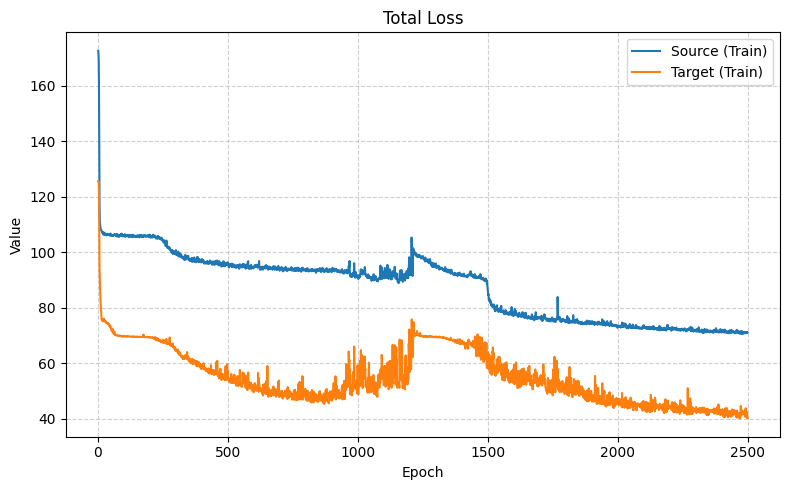

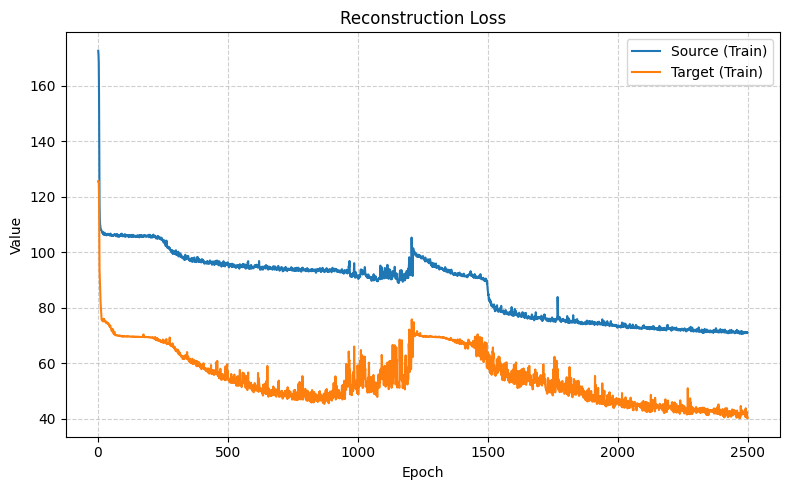

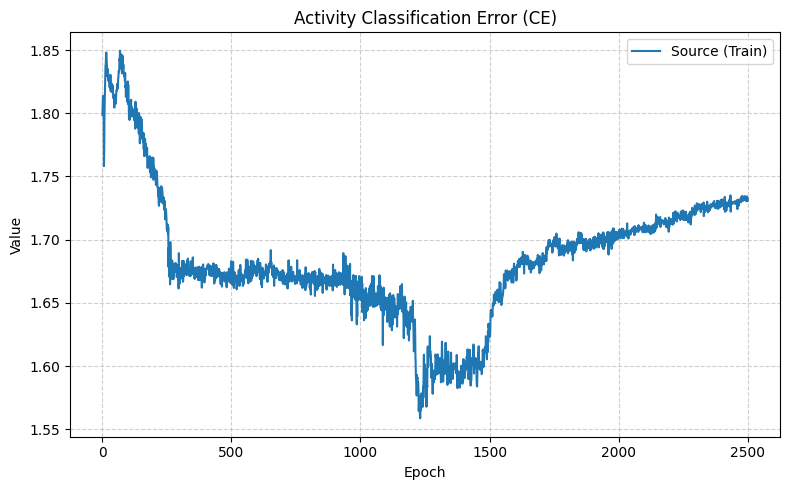

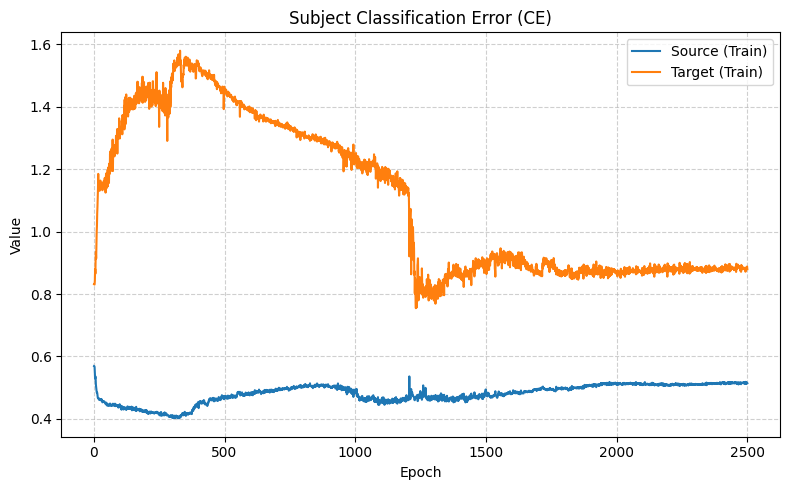

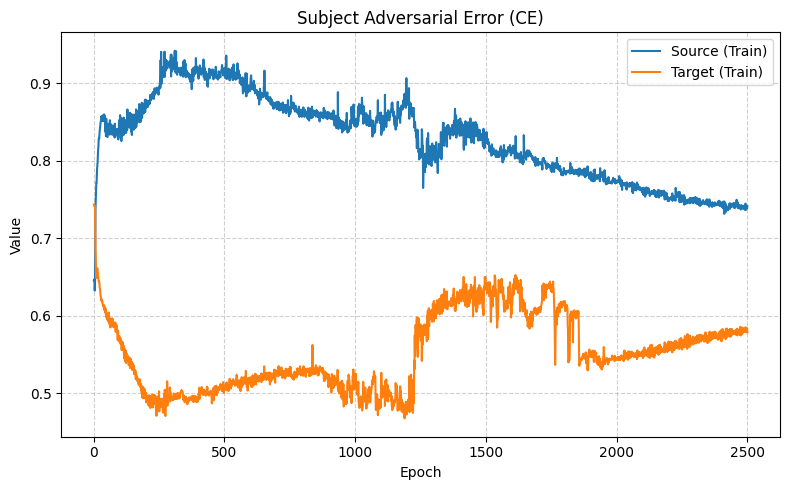

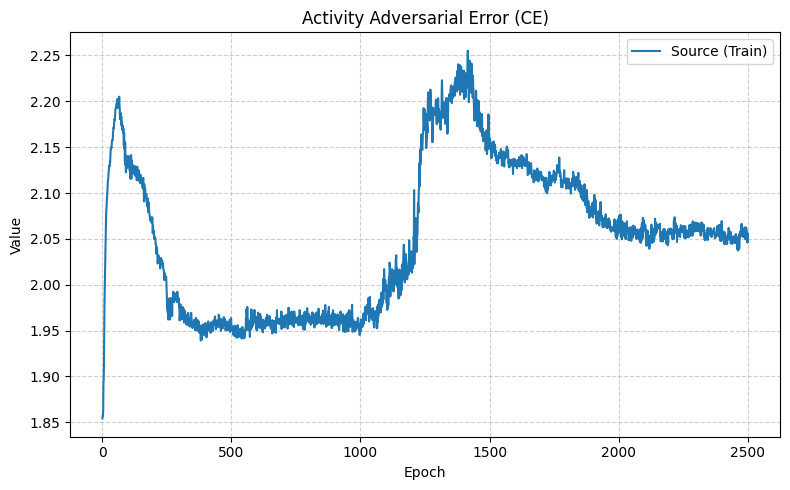

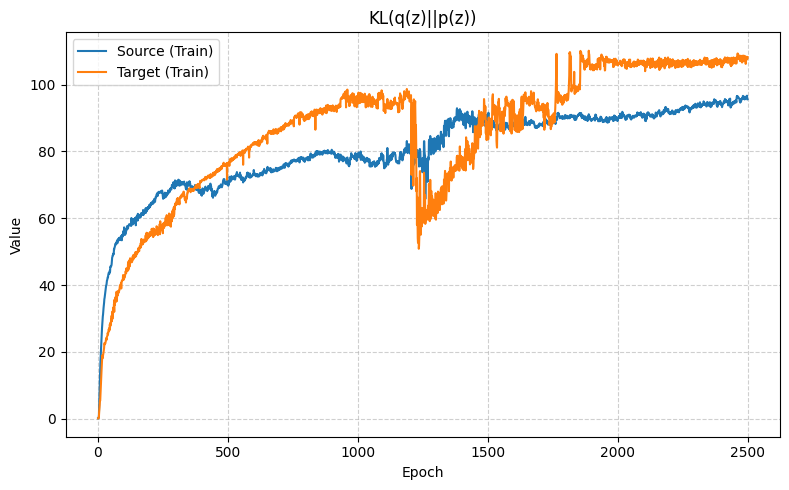

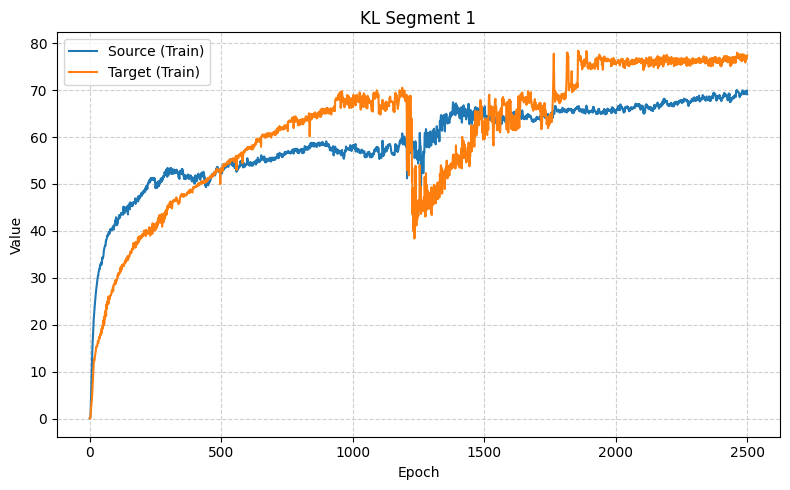

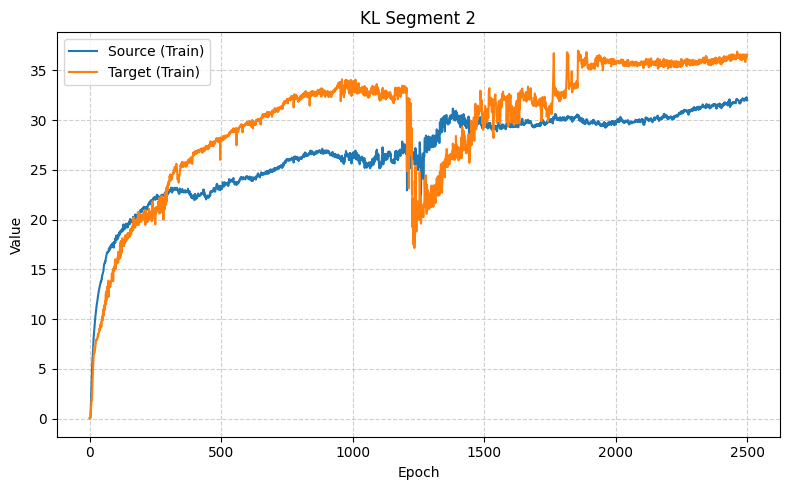

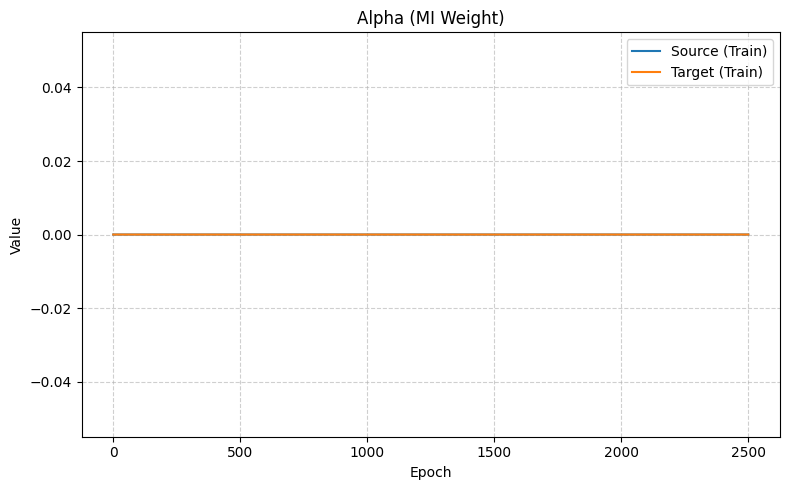

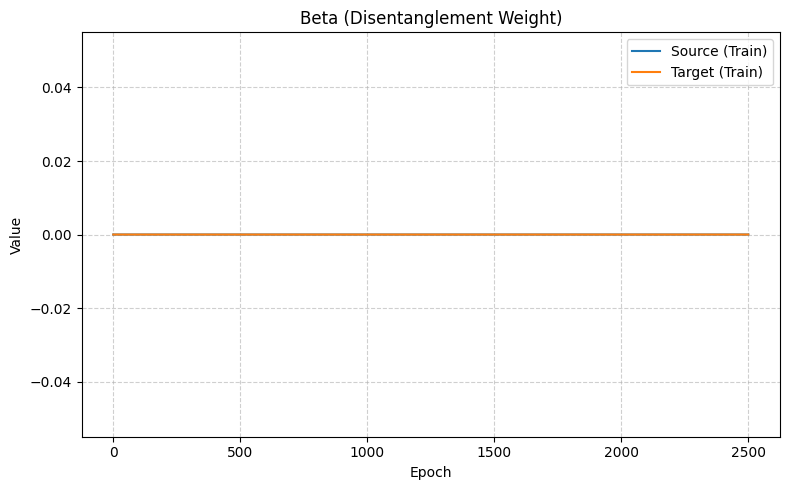

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_series(history, split_name, metric, prefix=None, default=np.nan):
    """
    split_name: 'train' or 'val' (must be keys in history)
    metric: base metric name, e.g. 'recon', 'loss_total'
    prefix: None (use metric as-is) OR 'src_' / 'tgt_' (prepend)
    """
    if split_name not in history:
        return None

    full_key = f"{prefix}{metric}" if prefix else metric
    out = []
    for d in history[split_name]:
        out.append(d.get(full_key, default))
    return np.asarray(out, dtype=float)

epochs = np.asarray(history.get("epoch", np.arange(len(history.get("train", [])))), dtype=int)

metrics_to_plot = [
    ("loss_total", "Total Loss"),
    ("recon", "Reconstruction Loss"),
    ("cls", "Activity Classification Error (CE)"),
    ("subj", "Subject Classification Error (CE)"),
    ("subj_adv", "Subject Adversarial Error (CE)"),
    ("act_adv", "Activity Adversarial Error (CE)"),
    ("kl_qz_pz", "KL(q(z)||p(z))"),
    ("kl_seg1", "KL Segment 1"),
    ("kl_seg2", "KL Segment 2"),
    ("alpha", "Alpha (MI Weight)"),
    ("beta", "Beta (Disentanglement Weight)"),
]

for metric, title in metrics_to_plot:
    src = get_series(history, "train", metric, prefix="src_")   # source from train dicts
    tgt = get_series(history, "train", metric, prefix="tgt_")   # target from train dicts
    val = get_series(history, "val",   metric, prefix=None)     # val dicts (unprefixed), if logged

    # Skip if absolutely nothing exists
    has_any = False
    for s in (src, tgt, val):
        if s is not None and not np.all(np.isnan(s)):
            has_any = True
            break
    if not has_any:
        continue

    plt.figure(figsize=(8, 5))

    if src is not None and not np.all(np.isnan(src)):
        plt.plot(epochs[:len(src)], src, label="Source (Train)")
    if tgt is not None and not np.all(np.isnan(tgt)):
        plt.plot(epochs[:len(tgt)], tgt, label="Target (Train)")
    # if val is not None and not np.all(np.isnan(val)):
        # plt.plot(epochs[:len(val)], val, label="Val")

    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


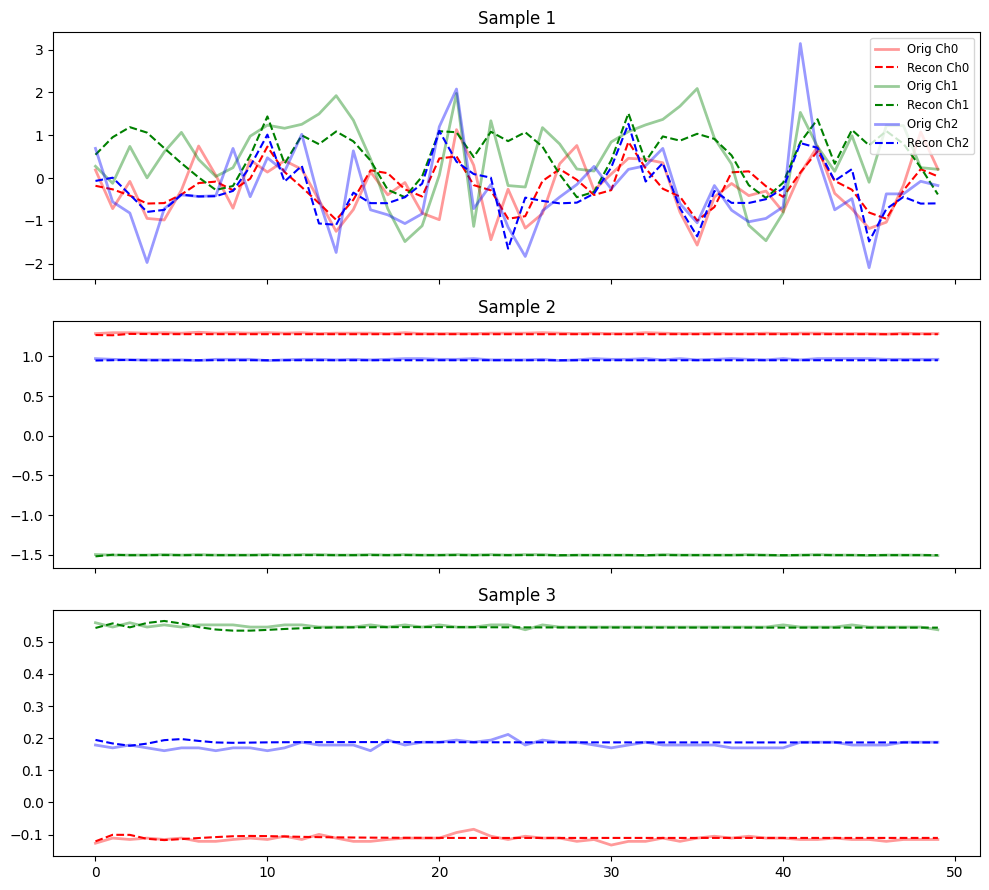

In [ ]:
# --- Visualization: Original vs Regenerated ---
import matplotlib.pyplot as plt
import torch
import numpy as np
# Ensure model is in eval mode
model.eval()
# Get a batch
this_set = dl_test

try:
    dl_test_vis = torch.utils.data.DataLoader(
    this_set.dataset,
    batch_size=this_set.batch_size,
    shuffle=True,
    num_workers=getattr(this_set, "num_workers", 0),
    pin_memory=getattr(this_set, "pin_memory", False),
    drop_last=False,
    )

    x_val_vis, _, _ = next(iter(dl_test_vis))

except NameError:
    # If dl_val is not defined, try to find it or recreate it (fallback)
    print("dl_val not found in scope for this cell, assuming it exists from previous cells.")
    # For safety in the standalone cell, we rely on the notebook state.
    pass
x_val_vis = x_val_vis.to(device)
with torch.no_grad():
    res = model(x_val_vis)
    x_recon = res.x_recon
# Move to CPU
x_orig = x_val_vis.cpu().numpy()
x_recon = x_recon.cpu().numpy()
# Plot first 3 samples
n_samples = 3
# Handle case where batch is smaller than n_samples
n_samples = min(n_samples, x_orig.shape[0])
fig, axes = plt.subplots(n_samples, 1, figsize=(10, 3*n_samples), sharex=True)
# Ensure iterable if n_samples=1
if n_samples == 1: axes = [axes]
elif not isinstance(axes, (list, np.ndarray)): axes = [axes]
# Channel config
n_channels = x_orig.shape[2]
# Using standard colors for x,y,z
colors = ['r', 'g', 'b', 'c', 'm', 'y']
labels = ['ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5']
for i in range(n_samples):
    ax = axes[i]

    for c in range(min(n_channels, len(colors))):
        ax.plot(x_orig[i, :, c], label=f'Orig Ch{c}', color=colors[c], linestyle='-', alpha=0.4, linewidth=2)
        ax.plot(x_recon[i, :, c], label=f'Recon Ch{c}', color=colors[c], linestyle='--', linewidth=1.5)
        # break

    ax.set_title(f"Sample {i+1}")
    # Only put legend on the first plot to avoid clutter
    if i == 0:
        ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
print(x_orig.mean())        # global mean
print(x_recon.mean())    # reconstructed mean
print(x_recon.std().mean())  # per-sample temporal std


0.18433006
0.19459337
0.75029856


Check Disentanglement

In [ ]:
from src.analysis.disentanglement import discriminability_table_for_model

stats = discriminability_table_for_model(model, dl_source=dl_train, dl_target=dl_test, device=device)
print("g_d / mu_subj:", stats["mu_subj"])
print("g_y / mu_act:", stats["mu_act"])



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


g_d / mu_subj: {'Acc/D-S': 0.9162384378211716, 'Acc/D-T': 0.8821510297482837, 'Acc/C-S': 0.9958890030832477, 'Acc/C-T': 0.1956521739130435, 'AUC/C-S': nan, 'AUC/C-T': nan}
g_y / mu_act: {'Acc/D-S': 0.9804727646454265, 'Acc/D-T': 0.9908466819221968, 'Acc/C-S': 0.998972250770812, 'Acc/C-T': 0.584096109839817, 'AUC/C-S': nan, 'AUC/C-T': nan}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
